### import packages

In [24]:
import numpy as np
import subprocess
from pathlib import Path
import os
import open3d as o3d
import vedo
import json
import importlib
import sys
from PIL import Image

### Set Output Path

In [25]:
output_path = r'c:/Users/Tobias/Documents/Masterarbeit_lokal/synthetic_pipeline/meshroom_data/static_BP_02_60cam_15x4'

### loading reconstructed data

In [26]:
# Define the evaluation_path by combining the output_path and "Evaluation" directory
evaluation_path = Path(output_path) / "Evaluation"
# Initialize an empty dictionary to store the read variables
variables = {}
# Open the cache.txt file located in the evaluation_path directory in read mode
with open((evaluation_path / "cache.txt"), 'r') as cache_file:
    # Iterate through each line in the file
    for line in cache_file:
        # Split each line by the colon ':' to separate variable name and value
        name, value = line.strip().split(":", 1)
        # Add the variable name and value pair to the variables dictionary after stripping whitespace
        variables[name.strip()] = value.strip()
# Access the read variables from the dictionary
project_name = variables.get("project_name", "")
output_path = variables.get("output_path", "")
image_dir = variables.get("image_dir", "")
obj_path = variables.get("obj_path", "")
# Print out the read variables
print("Read Variables:")
print("Project Name:", project_name)
print("Output Path:", output_path)
print("Image Directory:", image_dir)
print("OBJ Path:", obj_path)

Read Variables:
Project Name: static_BP_02_60cam_15x4
Output Path: c:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\meshroom_data\static_BP_02_60cam_15x4
Image Directory: C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\blender_data\static_BP_02_60cam_15x4
OBJ Path: C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\BP_02\centered\BP_2_Model.obj


#### plot reconstructed mesh

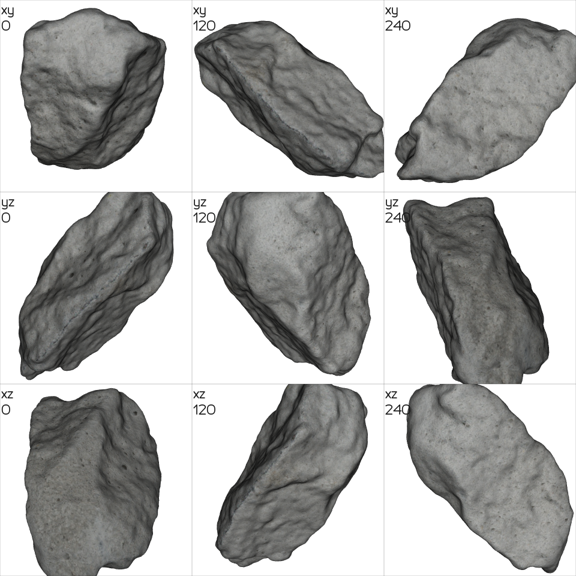

In [27]:
importlib.reload(sys.modules['src.plot_mesh_vedo']) if 'src.plot_mesh_vedo' in sys.modules else None
from src.plot_mesh_vedo import plot_mesh_vedo
fig,screenshot_path = plot_mesh_vedo(project_name,evaluation_path)
img = Image.open(screenshot_path)
scale = 0.6
display(img.resize(( int(img.width * scale), int(img.height * scale))))

### Postprocessing

#### Camera Location and Orientation

In [28]:
importlib.reload(sys.modules['src.CameraPreprocessing']) if 'src.CameraPreprocessing' in sys.modules else None
from src.CameraPreprocessing import read_camera_alignment_reconstruction, read_camera_alignment_reference, match_cameras
cams_rec = read_camera_alignment_reconstruction(output_path)
cams_ref = read_camera_alignment_reference(image_dir)
cams_rec, cams_ref  = match_cameras(cams_rec,cams_ref)

#### Scaling factor

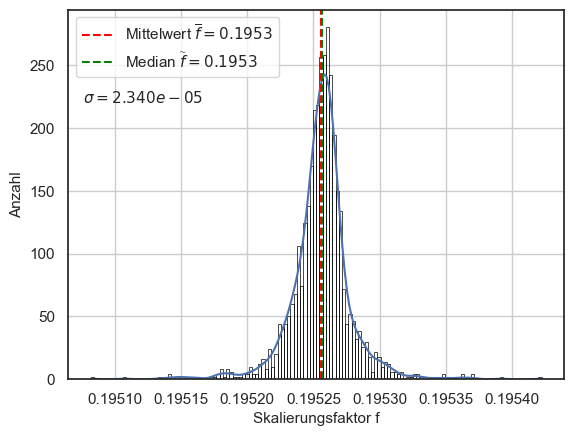

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [29]:
importlib.reload(sys.modules['src.scaling_factor']) if 'src.scaling_factor' in sys.modules else None
from src.scaling_factor import scaling_factor
importlib.reload(sys.modules['src.TransMatrix_Utils']) if 'src.TransMatrix_Utils' in sys.modules else None
from src.TransMatrix_Utils import Scale2Transformation4x4

factor_mean, factor_median, factor_std, fig = scaling_factor(cams_rec,cams_ref,evaluation_path) # approximate scaling factor 
scaling = factor_median             # Set the scaling factor
T_scale = Scale2Transformation4x4(scaling)

### Alignment of the reconstructed mesh with the ground truth

In [30]:
# Define file path to the mesh files
mesh_gt_path = obj_path                                                   # Path to ground truth mesh
mesh_r_path = evaluation_path / 'texturedMesh.obj'                        # Path to reconstructed mesh

#### Global Registration using open3d / Feature based alignment

In [31]:
ManualRegistration = False      
ThreePointRegistration = False

if ManualRegistration == False:
    importlib.reload(sys.modules['src.GlobalMeshRegistration']) if 'src.GlobalMeshRegistration' in sys.modules else None
    from src.GlobalMeshRegistration import GlobalMeshRegistration
    voxel_size = 1*10**(-3)
    draw_registration = 0 # choose 0,1,2,3,4 --> 0 = no plot appears --> 4 = all plots appears 
    T_global = GlobalMeshRegistration(mesh_r_path,mesh_gt_path,voxel_size,draw_registration,
                                    T_scale,ThreePointRegistration)
    T_global_path = evaluation_path / 'GlobalTransformationMatrix.txt'    # Define the file path for the saved transformation matrix
    np.savetxt(T_global_path,T_global)
else:
    T_global_path = evaluation_path / 'GlobalTransformationMatrix_manual.txt'    # Define the file path for the saved transformation matrix
    T_global = np.loadtxt(T_global_path)
#else: #Do It manually 
    # 1.) open CloudCompare
    # 2.) load texturedMesh (reconstructed) and the ground truth mesh (centered) 
    # 3.) deactivate normals on the ground truth mesh under Properties -> CC Object -> Normals
    # 4.) select both meshes by holding the control button. Important: First, select the ground truth mesh and then the reconstructed mesh 
    # 5.) scale the reconstructed mesh with the calculated scaling factor:
    #       - select the texturedMesh and go to edit -> Multiply/Scale --> enter the scaling factor and press Ok
    # 6.) Rotate the reconstructed Mesh (texturedMesh) with the Translate/Rotate Function in the top bar
    #   a) switch back and forth between the visibility of the objects and memorize distinctive spots on the ground truth mesh
    #   b) select the texturedMesh and use the Translate/Rotate Function
    #   c) rotate the texturedMesh so that the two meshes lie approximately on top of each other 
    # 7.) Finely Register the two Meshes
    #    a) select both meshes, click on the Finely Register Button on the top bar
    #    b) swap the meshes, if texturedMesh is not the "to be aligned"-Mesh
    #    c) click okay (disable adjust scale)
    # 8.) Export the Transformation Matrix
    #   a) select the texturedMesh.registered and export the transformation history under Properties --> Transformation history --> Export --> ASCII   
    #   b) save the File under "/../Evaluation/GlobalTransformationMatrix_manual.txt" 
    # 9.) Save the Registration inside a CloudCompare file 


:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: Downsample with a voxel size 0.001.
:: Estimate normal with search radius 0.002.
:: Compute FPFH feature with search radius 0.005.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.001,
   we use a liberal distance threshold 0.002.
RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.734944e-04, and correspondence_set size of 2737
Access transformation to get result.


#### Fine Registration using CloudCompare / Iterative Closest Point (ICP) algorithm

In [32]:
# Set parameters
save_meshes_all_at_once = False                 # Save the transformed reconstructed mesh with the Groud_truth mesh in a single file (uses a lot of hard disk space)
silent = True                                   # No GUI pops up and no clicks necessary
adjust_scale = True                            # Alignment of the Mesh with SCALING
# Define output format for meshes
output_format_mesh = "OBJ"                                              # Format can be one of the following: BIN, OBJ, PLY, STL, VTK, MA, FBX.

# Function to align the reconstruected mesh and to calculate the Mesh to Mesh distance
importlib.reload(sys.modules['src.FineMeshRegistration_and_MeshToMeshDistance']) if 'src.FineMeshRegistration_and_MeshToMeshDistance' in sys.modules else None
from src.FineMeshRegistration_and_MeshToMeshDistance import FineMeshRegistration_and_MeshToMeshDistance
params_CC = [silent,save_meshes_all_at_once,adjust_scale,output_format_mesh]
T,T_ICP,mesh_r_trans_path,log_path = FineMeshRegistration_and_MeshToMeshDistance(params_CC,evaluation_path,mesh_gt_path,mesh_r_path,output_format_mesh,T_global_path)

In [33]:
importlib.reload(sys.modules['src.TransMatrix_Utils']) if 'src.TransMatrix_Utils' in sys.modules else None
from src.TransMatrix_Utils import GetScaling_from_Transformation4x4
s_x,s_y,s_z = GetScaling_from_Transformation4x4(T_ICP)

Scaling in X direction: 1.0014022422129523
Scaling in Y direction: 1.001402247231122
Scaling in Z direction: 1.0014021959237251


### Cloud to Mesh: Mean Distance and Standard Deviation

In [34]:
# Reload the module 'read_c2m_distance_from_log' if it's already imported
importlib.reload(sys.modules['src.read_c2m_distance_from_log']) if 'src.read_c2m_distance_from_log' in sys.modules else None
from src.read_c2m_distance_from_log import read_c2m_distance_from_log
# Call the function to read mean distance and standard deviation from the log file
mean_distance, std_deviation = read_c2m_distance_from_log(log_path)

Cloud to Mesh Distance:
----------------------------------------
Global Mesh Registration
Mean distance: -1.16797e-05, Standard deviation: 8.99081e-05
--------------------
Closest Point Registration Procedure (ICP)
Mean distance: 1.02992e-07, Standard deviation: 3.60041e-05


### Comparison of volumes and surfaces

In [35]:
importlib.reload(sys.modules['src.EvaluateVolumeSurfaceArea']) if 'src.EvaluateVolumeSurfaceArea' in sys.modules else None
from src.EvaluateVolumeSurfaceArea import EvaluateVolumeSurfaceArea
EvaluateVolumeSurfaceArea(evaluation_path,mesh_gt_path,T_global,T)

Object                                          Volume (m^3)    Surface Area (m^2)    Sauter Diameter (mm)
--------------------------------------------  --------------  --------------------  ----------------------
Reconstructed Obj.                               6.85227e-06            0.00222162                 18.5062
Reconstructed Obj. (Scaling by CloudCompare)     6.88114e-06            0.00222785                 18.5321
Ground Truth                                     6.8807e-06             0.00239573                 17.2324


### Evaluation of the reconstructed Cameras

camera parameters in relation to the global coordinate system

In [36]:
for i, cam in enumerate(cams_rec): cam.Transformation2WorldCoordinateSystem(T); cams_rec[i] = cam

#### real cameras

initialize camera pose visualizer


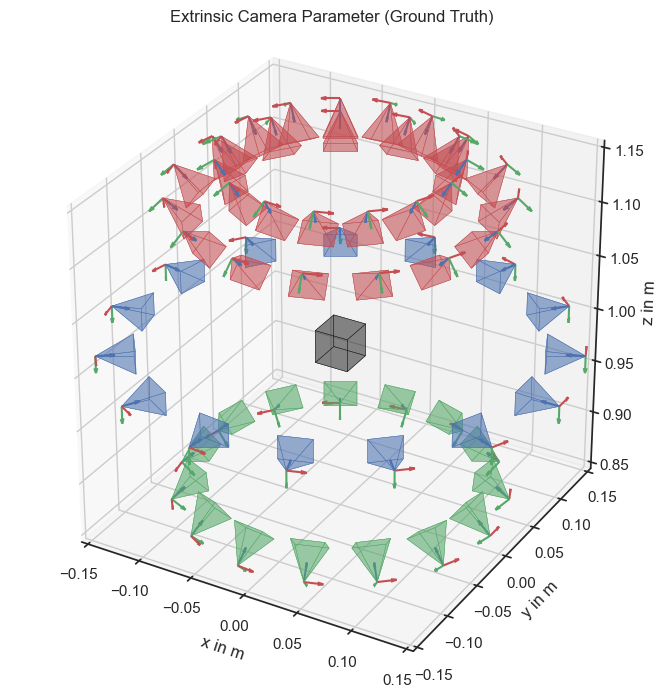

<Figure size 640x480 with 0 Axes>

In [37]:
importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
from src.camera_pose_visualizer import CameraPoseVisualizer

# define parameters @TODO -->  Load automatically
focal_length = 16*10**(-3)
sensor_width = 7.12*10**(-3)
aspect_ratio = 7.12/5.33

scale = 2

# visualize cameras
visualizer = CameraPoseVisualizer([-0.15, 0.15], [-0.15, 0.15], [0.85, 1.15])
visualizer.load_cameras(cams_ref,focal_length,aspect_ratio,sensor_width,scale)
visualizer.load_cube(cams_ref)      
###matplotlib inline
##%matplotlib qt 
visualizer.show('Extrinsic Camera Parameter (Ground Truth)')
path = evaluation_path / "Extrinsics_cams_reference"
visualizer.save(path)

#### Comparison between reference and reconstructed cameras

initialize camera pose visualizer


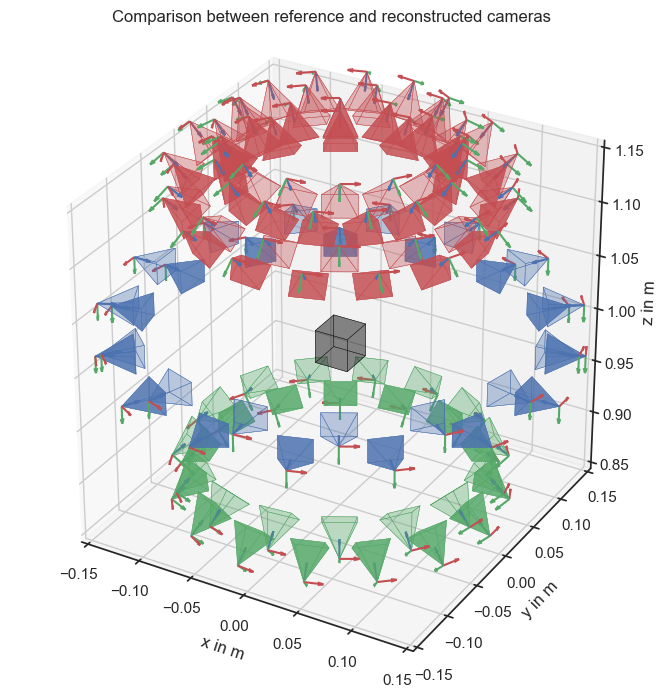

<Figure size 640x480 with 0 Axes>

In [38]:
importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
from src.camera_pose_visualizer import CameraPoseVisualizer
visualizer2 = CameraPoseVisualizer([-0.15, 0.15], [-0.15, 0.15], [0.85, 1.15])
visualizer2.load_cameras(cams_rec,focal_length,aspect_ratio,sensor_width,scale,alpha=0.2)
visualizer2.load_cameras(cams_ref,focal_length,aspect_ratio,sensor_width,scale,alpha=0.6)
visualizer2.load_cube(cams_ref)      
visualizer2.show('Comparison between reference and reconstructed cameras')
path = evaluation_path / "Extrinsics_cams_comparison"
visualizer2.save(path)
###%matplotlib qt

In [39]:
importlib.reload(sys.modules['src.TransMatrix_Utils']) if 'src.TransMatrix_Utils' in sys.modules else None
from src.TransMatrix_Utils import Get_Location_Rotation3x3_Scale_from_Transformation4x4
#create dataset
x = np.ones([len(cams_rec),3])*(42)
y = np.ones([len(cams_rec),3])*(42)
empty_rows = []
for i,cam_rec in enumerate(cams_rec):
    ind_ref = cam_rec.CorrespondigIndex
    if ind_ref != None:
        cam_ref = cams_ref[ind_ref]
        location_ref,_,_ = Get_Location_Rotation3x3_Scale_from_Transformation4x4(cam_ref.Transformation)
        location_rec,_,_ = Get_Location_Rotation3x3_Scale_from_Transformation4x4(cam_rec.Transformation)
        x[i,:] = location_rec
        y[i,:] = location_ref
    else:
        empty_rows.append(i)
empty_rows
# filter x and y
x = np.delete(x, empty_rows, axis=0)
y = np.delete(y, empty_rows, axis=0)

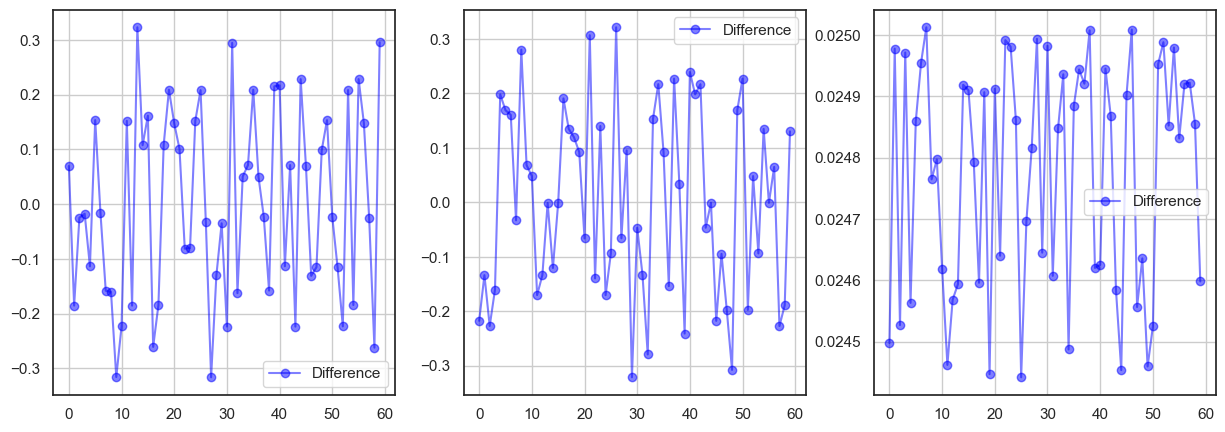

In [40]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].plot(x[:, 0]-y[:, 0], label='Difference', color='blue', alpha=0.5, marker='o')
axs[1].plot(x[:, 1]-y[:, 1], label='Difference', color='blue', alpha=0.5,marker='o')
axs[2].plot(x[:, 2]-y[:, 2], label='Difference', color='blue', alpha=0.5,marker='o')
for i,ax in enumerate(axs):
    ax.grid(True)
    ax.legend()

plt.show()

In [41]:
# importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
# from src.camera_pose_visualizer import CameraPoseVisualizer
# ####%matplotlib qt
# visualizer3 = CameraPoseVisualizer([-0.15, 0.15], [-0.15, 0.15], [0.85, 1.15])

# i = 10
# visualizer3.load_cameras([cams_ref[i]],focal_length,aspect_ratio,sensor_width,scale,alpha=0.2)

# ind_rec = cams_ref[i].CorrespondigIndex
# visualizer3.load_cameras([cams_rec[ind_rec]],focal_length,aspect_ratio,sensor_width,scale,alpha=0.6)

# print(cams_ref[i].ImageFileName)
# print(cams_rec[ind_rec].ImageFileName)


In [42]:
# importlib.reload(sys.modules['src.CameraPreprocessing']) if 'src.CameraPreprocessing' in sys.modules else None
# from src.CameraPreprocessing import read_camera_alignment_reconstruction, read_camera_alignment_reference, match_cameras
# cams_rec = read_camera_alignment_reconstruction(output_path)
# cams_ref = read_camera_alignment_reference(image_dir)
# cams_rec, cams_ref  = match_cameras(cams_rec,cams_ref)

# importlib.reload(sys.modules['src.camera_pose_visualizer']) if 'src.camera_pose_visualizer' in sys.modules else None
# from src.camera_pose_visualizer import CameraPoseVisualizer
# %matplotlib qt

# scale = 10
# cam_rec = cams_rec[1]
# cam_rec.Transformation2WorldCoordinateSystem(T)
# visualizer4 = CameraPoseVisualizer([-1, 1], [-1, 1], [-1, 1])
# visualizer4.load_cameras([cam_rec],focal_length,aspect_ratio,sensor_width,scale,alpha=0.2)


In [43]:
# import pandas as pd
# df = pd.read_csv(r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\blender_data\1cam_4\CameraPositioningInMeters.csv")

In [44]:
# df

In [45]:
# visualizer4 = CameraPoseVisualizer([-0.15, 0.15], [-0.15, 0.15], [0.85, 1.15])
# extrinsic = np.eye(4); extrinsic 
# visualizer4.extrinsic2pyramid(extrinsic, 'r', focal_length, aspect_ratio,sensor_width,scale_rel=2)

In [46]:
# cams_rec[1].ImageFileName